# Import Libraries

In [1]:
import numpy as np
import cv2
import os
import imageio.v2 as imageio
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from scipy import ndimage

# Extracting the dataset

In [2]:
import zipfile
# Define the path to the ZIP file
zip_path = 'Train.zip'  # Adjust the path as necessary

# Define the directory to extract files to
extract_dir = 'extracted_dataset'

# Create the extract directory if it does not exist
os.makedirs(extract_dir, exist_ok=True)

# Open the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Extract all the contents into the specified directory
    zip_ref.extractall(extract_dir)

print(f'Files extracted to {extract_dir}')


Files extracted to extracted_dataset


# Loading the dataset

In [3]:
from PIL import Image

# Load high quality images
hq_path = r'extracted_dataset/Train/high'
hq_files = [os.path.join(hq_path, f) for f in os.listdir(hq_path) if f.endswith('.png')]
hq_images = []

hq_files.sort()
for fname in hq_files:
    img = Image.open(fname)
    img_array = np.array(img)
    hq_images.append(img_array)
hq_images = np.array(hq_images)

# Load low quality images
lq_path = r'extracted_dataset/Train/low'
lq_files = [os.path.join(lq_path, f) for f in os.listdir(lq_path) if f.endswith('.png')]
lq_images = []

lq_files.sort()
for fname in lq_files:
    img = Image.open(fname)
    img_array = np.array(img)
    lq_images.append(img_array)
lq_images = np.array(lq_images)

print(hq_images.shape)
print(lq_images.shape)

(485, 400, 600, 3)
(485, 400, 600, 3)


# Delete the .DS_Store file

In [4]:
# import os

# def remove_ds_store(directory):
#     """
#     Recursively remove all .DS_Store files in the specified directory and its subdirectories.
    
#     Args:
#     directory (str): The path to the directory to clean.
#     """
#     for root, dirs, files in os.walk(directory):
#         for file in files:
#             if file == '.DS_Store':
#                 file_path = os.path.join(root, file)
#                 try:
#                     os.remove(file_path)
#                     print(f"Removed: {file_path}")
#                 except Exception as e:
#                     print(f"Error removing {file_path}: {e}")

# # Define the directories to clean
# directories_to_clean = ['/content/Train/low', '/content/Train/high']

# # Remove .DS_Store files from the specified directories
# for directory in directories_to_clean:
#     remove_ds_store(directory)

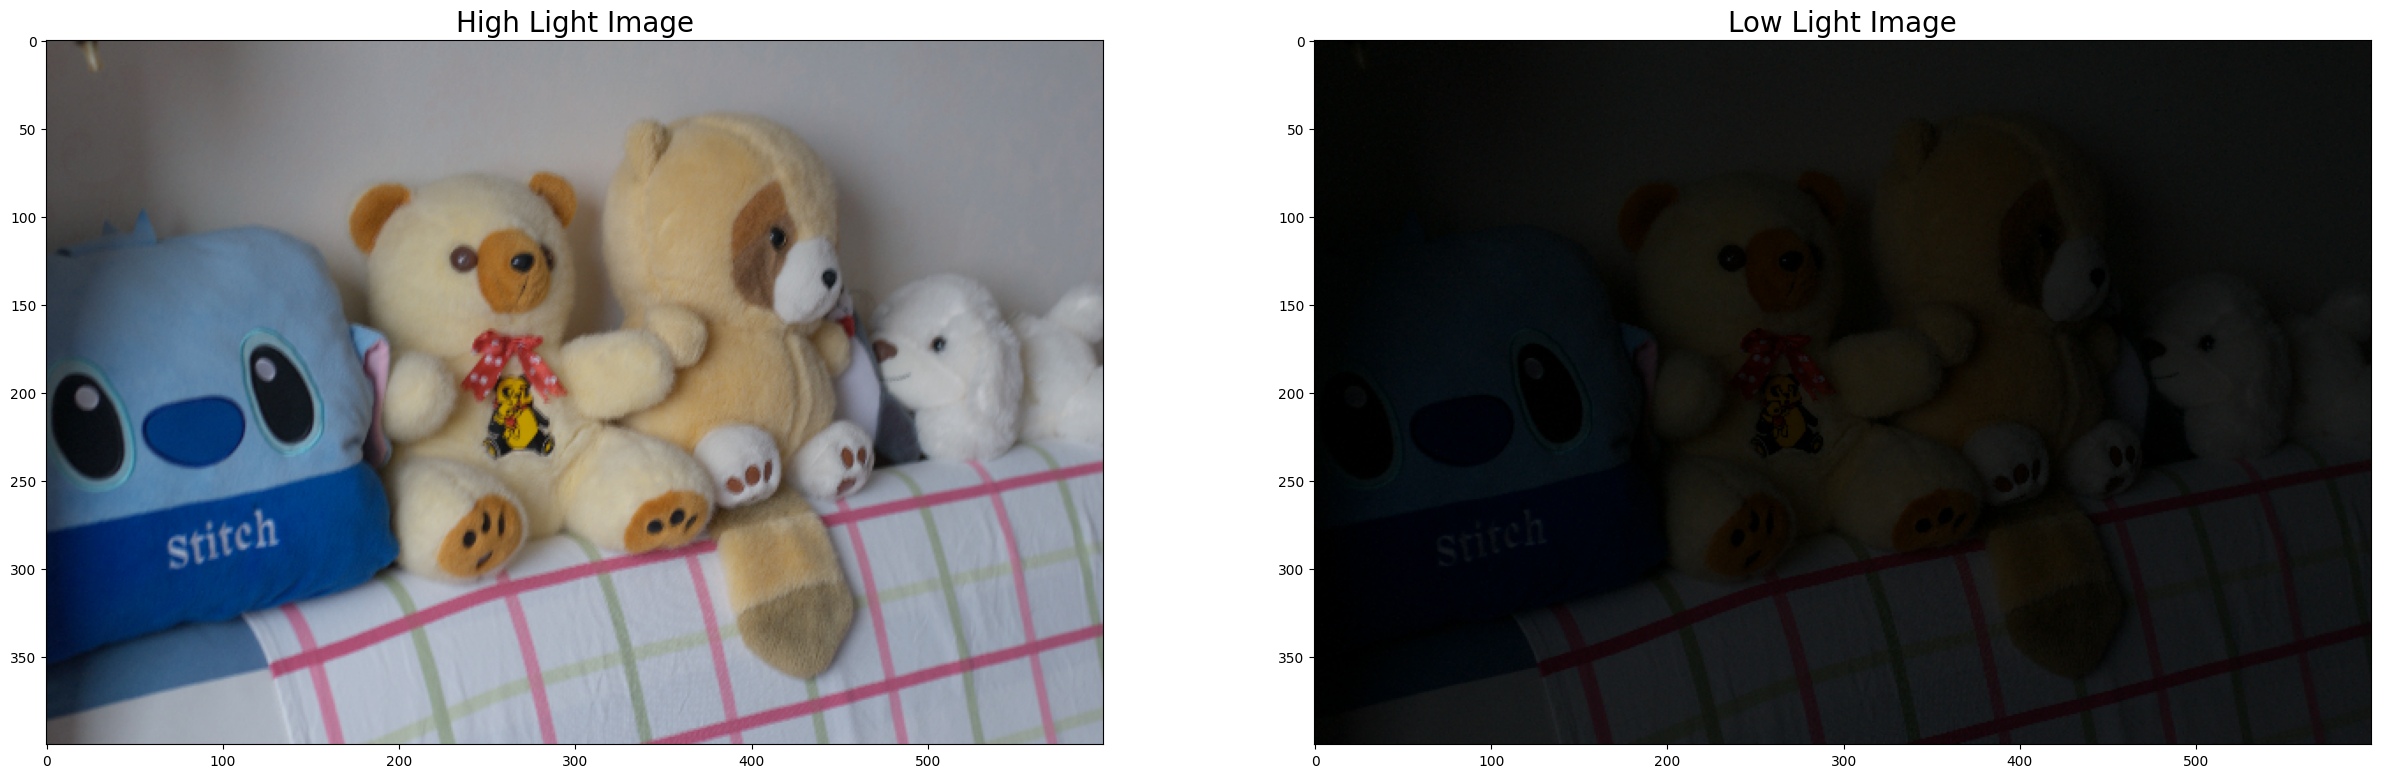

In [5]:
plt.figure(figsize=(30,30))
plt.subplot(1,2,1)
plt.title("High Light Image",fontsize=20)
plt.imshow(hq_images[0])

plt.subplot(1,2,2)
plt.title("Low Light Image",fontsize=20)
plt.imshow(lq_images[0])

# Creating Model

In [6]:
def psnr_metric(y_true, y_pred):
    psnr_value=tf.image.psnr(y_true, y_pred, max_val=1.0)
    return psnr_value

In [7]:
from tensorflow.keras.layers import Conv2D, Add, Input, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

kernel_size = (3, 3)
activation_function = 'relu'
padding_type = 'same'
dropout_rate = 0.3

# Input layer
input_layer = Input(shape=(None, None, 3), name='img')

# Convolutional layers with batch normalization and dropout
conv1 = Conv2D(64, kernel_size, activation=activation_function, padding=padding_type)(input_layer)
bn1 = BatchNormalization()(conv1)
conv1_d = Dropout(dropout_rate)(bn1)

conv2 = Conv2D(64, kernel_size, activation=activation_function, padding=padding_type)(conv1_d)
bn2 = BatchNormalization()(conv2)
conv2_d = Dropout(dropout_rate)(bn2)

conv3 = Conv2D(64, kernel_size, activation=activation_function, padding=padding_type)(conv2_d)
bn3 = BatchNormalization()(conv3)
conv3_d = Dropout(dropout_rate)(bn3)

conv4 = Conv2D(64, kernel_size, activation=activation_function, padding=padding_type)(conv3_d)
bn4 = BatchNormalization()(conv4)
conv4_d = Dropout(dropout_rate)(bn4)

# Skip connections
skip1 = Add()([conv3_d, conv4_d])

# Additional convolutional layer
conv5 = Conv2D(64, kernel_size, activation=activation_function, padding=padding_type)(skip1)
bn5 = BatchNormalization()(conv5)
conv5_d = Dropout(dropout_rate)(bn5)

# Another skip connection
skip2 = Add()([conv2_d, conv5_d])

# Further convolutional layer
conv6 = Conv2D(64, kernel_size, activation=activation_function, padding=padding_type)(skip2)
bn6 = BatchNormalization()(conv6)
conv6_d = Dropout(dropout_rate)(bn6)

# Final skip connection
skip3 = Add()([conv1_d, conv6_d])

# Output layer with sigmoid activation
output_layer = Conv2D(1, kernel_size, activation='sigmoid', padding=padding_type)(skip3)

# Construct the model
denoising_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
denoising_model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=[tf.image.psnr])

# Summary of the model
denoising_model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   1792        ['img[0][0]']                    
                                64)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   256        ['conv2d[0][0]']                 
 alization)                     64)                                                           

In [8]:
denoising_model.compile(optimizer="adam", loss='mean_squared_error', metrics=[psnr_metric])

# Training the model

In [9]:
def GenerateInputs(X, Y):
    for i in range(len(X)):
        X_input = X[i].reshape(1, 400, 600, 3)
        Y_temp = Y[i] / 255
        if Y_temp.shape[-1] == 1:
            Y_temp = np.repeat(Y_temp, 3, axis=-1)  # Converting grayscale to RGB by repeating the channel
        Y_input = Y_temp.reshape(1, 400, 600, 3)
        yield (X_input, Y_input[:, :, :, 0:1])  # Ensuring that y_input has a single channel

denoising_model.fit(GenerateInputs(lq_images, hq_images), epochs=20, verbose=1, steps_per_epoch=20)  # This epoch number after testing

Epoch 1/20
20/20 [==============================] - 17s 195ms/step - loss: 0.0674 - psnr_metric: 12.0000
Epoch 2/20
20/20 [==============================] - 4s 193ms/step - loss: 0.0427 - psnr_metric: 13.8417
Epoch 3/20
20/20 [==============================] - 4s 194ms/step - loss: 0.0349 - psnr_metric: 14.9164
Epoch 4/20
20/20 [==============================] - 4s 194ms/step - loss: 0.0335 - psnr_metric: 15.1226
Epoch 5/20
20/20 [==============================] - 4s 194ms/step - loss: 0.0324 - psnr_metric: 15.2276
Epoch 6/20
20/20 [==============================] - 4s 197ms/step - loss: 0.0310 - psnr_metric: 15.5071
Epoch 7/20
20/20 [==============================] - 4s 198ms/step - loss: 0.0286 - psnr_metric: 15.8530
Epoch 8/20
20/20 [==============================] - 4s 202ms/step - loss: 0.0317 - psnr_metric: 15.5577
Epoch 9/20
20/20 [==============================] - 4s 204ms/step - loss: 0.0304 - psnr_metric: 16.0504
Epoch 10/20
20/20 [==============================] - 4s 207ms/s

# Saving the trained model

In [10]:
denoising_model.save('mymodel.h5')

# Testing the model

In [22]:
def load_images_from_folder(folder_path):
    all_files = sorted(glob.glob(folder_path + "/*"))
    images = [imageio.imread(file) for file in all_files]
    return np.array(images)

# Define the path to your images
path_low = r'extracted_dataset/Train/low'
path_high = r'extracted_dataset/Train/high'
# Load the low light images
X = load_images_from_folder(path_low)

#Load the high light images
Y = load_images_from_folder(path_high)

# Loading our model

In [12]:
from tensorflow.keras.models import load_model

# Define the custom PSNR metric function
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

# Load the model with the custom PSNR metric
model = load_model('mymodel.h5', custom_objects={'psnr_metric': psnr_metric})

# Optional: Print the model summary to verify
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   1792        ['img[0][0]']                    
                                64)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   256        ['conv2d[0][0]']                 
 alization)                     64)                                                           

In [13]:
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def enhance_image(img, index, flag, psnr_list):
    if index == 0:
        return img

    elif flag == 1:
        h, w, c = img.shape
        test = model.predict(img.reshape(1, h, w, 3))
        temp = img / 255.0
        enhanced_image = temp + ((test[0,:,:,:] * temp) * (1 - temp))
        psnr_value = psnr_metric(tf.convert_to_tensor(img, dtype=tf.float32), tf.convert_to_tensor(enhanced_image * 255, dtype=tf.float32)).numpy()
        print(f"PSNR: {psnr_value:.4f}")
        psnr_list.append(psnr_value)
        index -= 1
        flag = 0
        return enhance_image(enhanced_image, index, flag, psnr_list)

    else:
        h, w, c = img.shape
        temp = model.predict(img.reshape(1, h, w, 3))
        enhanced_image = img + ((temp[0,:,:,:] * img) * (1 - img))
        psnr_value = psnr_metric(tf.convert_to_tensor(img, dtype=tf.float32), tf.convert_to_tensor(enhanced_image, dtype=tf.float32)).numpy()
        print(f"PSNR: {psnr_value:.4f}")
        psnr_list.append(psnr_value)
        index -= 1
        return enhance_image(enhanced_image, index, flag, psnr_list)


In [37]:
def plot_images(low_light_image, enhanced_image, high_light_image):
    plt.figure(figsize=(20, 15))

    # Plot low light image
    plt.subplot(1, 3, 1)
    plt.title("Low Light Image", fontsize=16)
    plt.imshow(low_light_image)
    plt.axis('off')

    # Plot enhanced image
    plt.subplot(1, 3, 2)
    plt.title("Enhanced Image", fontsize=16)
    plt.imshow(enhanced_image)
    plt.axis('off')
    
    # Plot High light image
    plt.subplot(1, 3, 3)
    plt.title("High Light Image", fontsize=16)
    plt.imshow(enhanced_image)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    


# Examples

1/1 [==============================] - 0s 39ms/step
PSNR: -19.0615
1/1 [==============================] - 0s 32ms/step
PSNR: 36.0969
1/1 [==============================] - 0s 41ms/step
PSNR: 35.0303
1/1 [==============================] - 0s 37ms/step
PSNR: 34.0489
1/1 [==============================] - 0s 35ms/step
PSNR: 33.1616
1/1 [==============================] - 0s 33ms/step
PSNR: 32.3763
1/1 [==============================] - 0s 37ms/step
PSNR: 31.7007
1/1 [==============================] - 0s 37ms/step
PSNR: 31.1417
Average PSNR value of Enhanced Image:  26.811851501464844


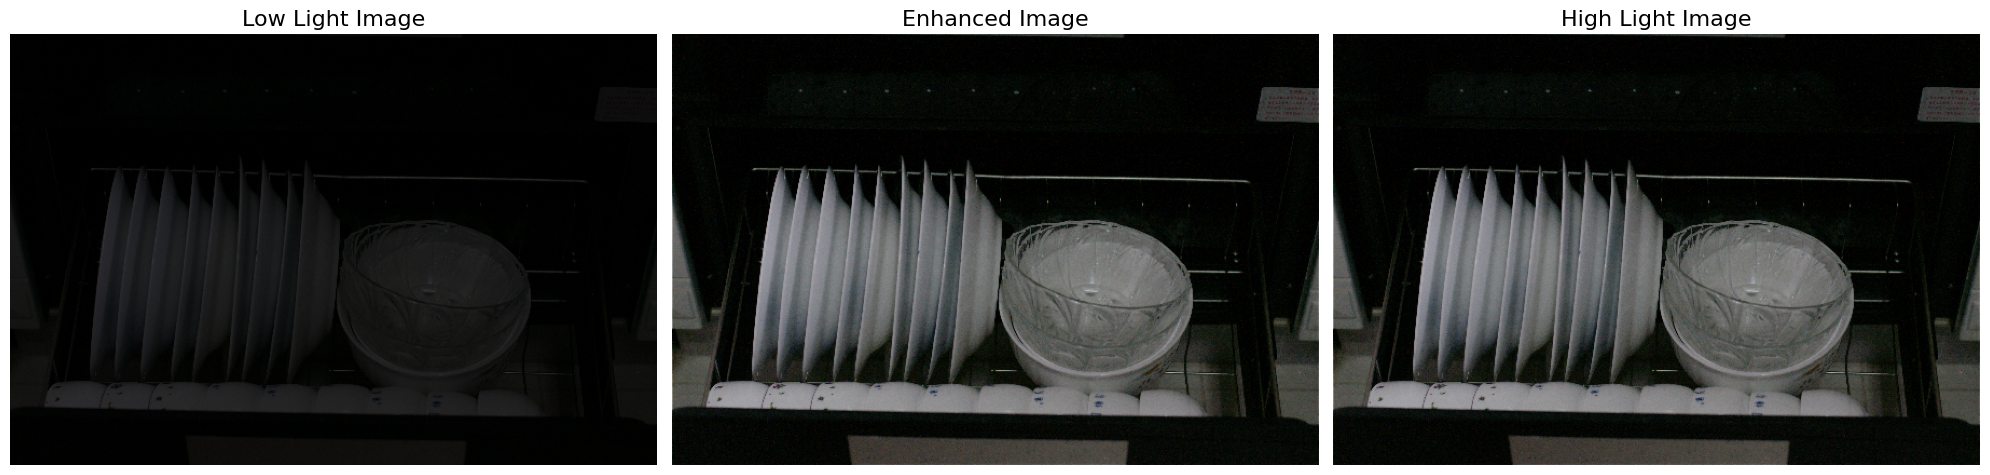

In [48]:
# Test 1:
low_light_image = X[1]
high_light_image = Y[1]
psnr_list = []
enhanced_image = enhance_image(low_light_image, 8, 1, psnr_list)
print("Average PSNR value of Enhanced Image: " , sum(psnr_list)/len(psnr_list))
plot_images(low_light_image, enhanced_image, high_light_image)

1/1 [==============================] - 0s 20ms/step
PSNR: -19.3966
1/1 [==============================] - 0s 22ms/step
PSNR: 35.0991
1/1 [==============================] - 0s 21ms/step
PSNR: 33.9142
1/1 [==============================] - 0s 120ms/step
PSNR: 32.7974
1/1 [==============================] - 0s 25ms/step
PSNR: 31.7697
1/1 [==============================] - 0s 26ms/step
PSNR: 30.8358
1/1 [==============================] - 0s 29ms/step
PSNR: 29.9954
1/1 [==============================] - 0s 26ms/step
PSNR: 29.2542
Average PSNR value of Enhanced Image:  25.533660650253296


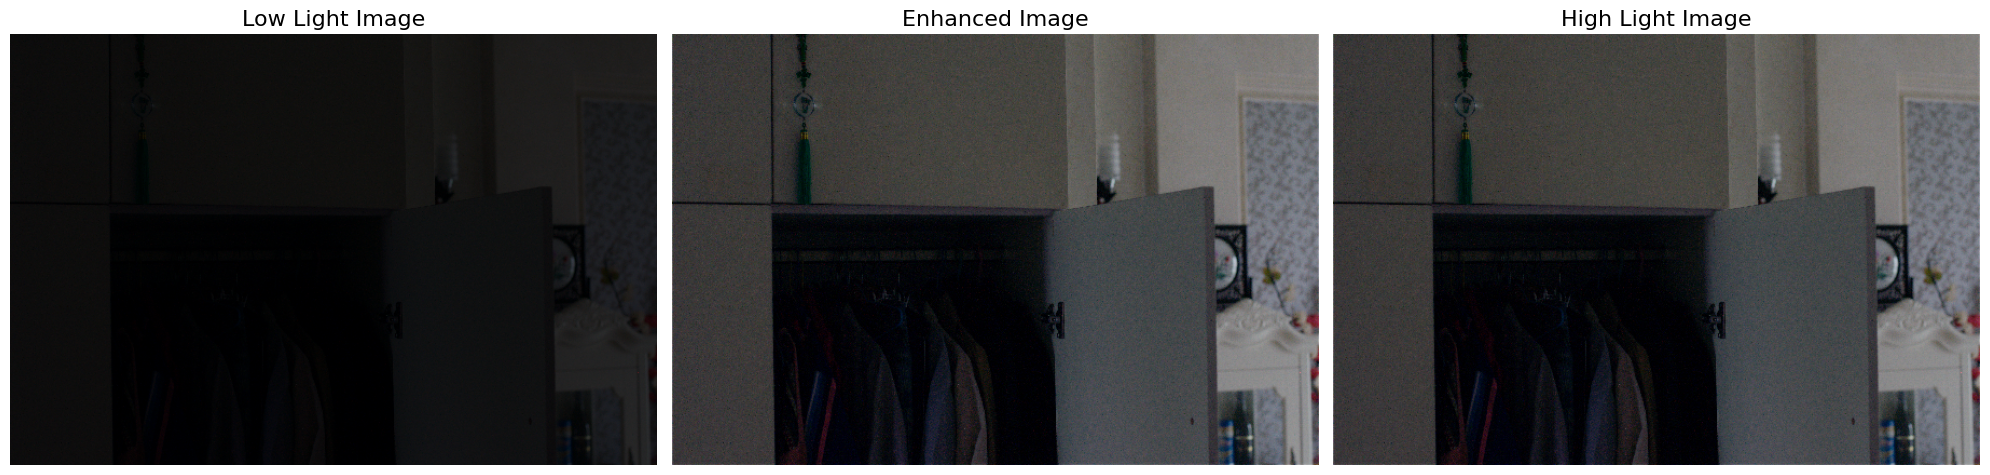

In [47]:
# Test 2:

low_light_image = X[50]
high_light_image = Y[50]
psnr_list = []
enhanced_image = enhance_image(low_light_image, 8, 1, psnr_list)
print("Average PSNR value of Enhanced Image: " , sum(psnr_list)/len(psnr_list))
plot_images(low_light_image, enhanced_image, high_light_image)

1/1 [==============================] - 0s 23ms/step
PSNR: -20.2041
1/1 [==============================] - 0s 20ms/step
PSNR: 34.9496
1/1 [==============================] - 0s 20ms/step
PSNR: 33.8569
1/1 [==============================] - 0s 23ms/step
PSNR: 32.8419
1/1 [==============================] - 0s 22ms/step
PSNR: 31.9117
1/1 [==============================] - 0s 22ms/step
PSNR: 31.0724
1/1 [==============================] - 0s 25ms/step
PSNR: 30.3296
1/1 [==============================] - 0s 27ms/step
PSNR: 29.6872
Average PSNR value of Enhanced Image:  25.55565571784973


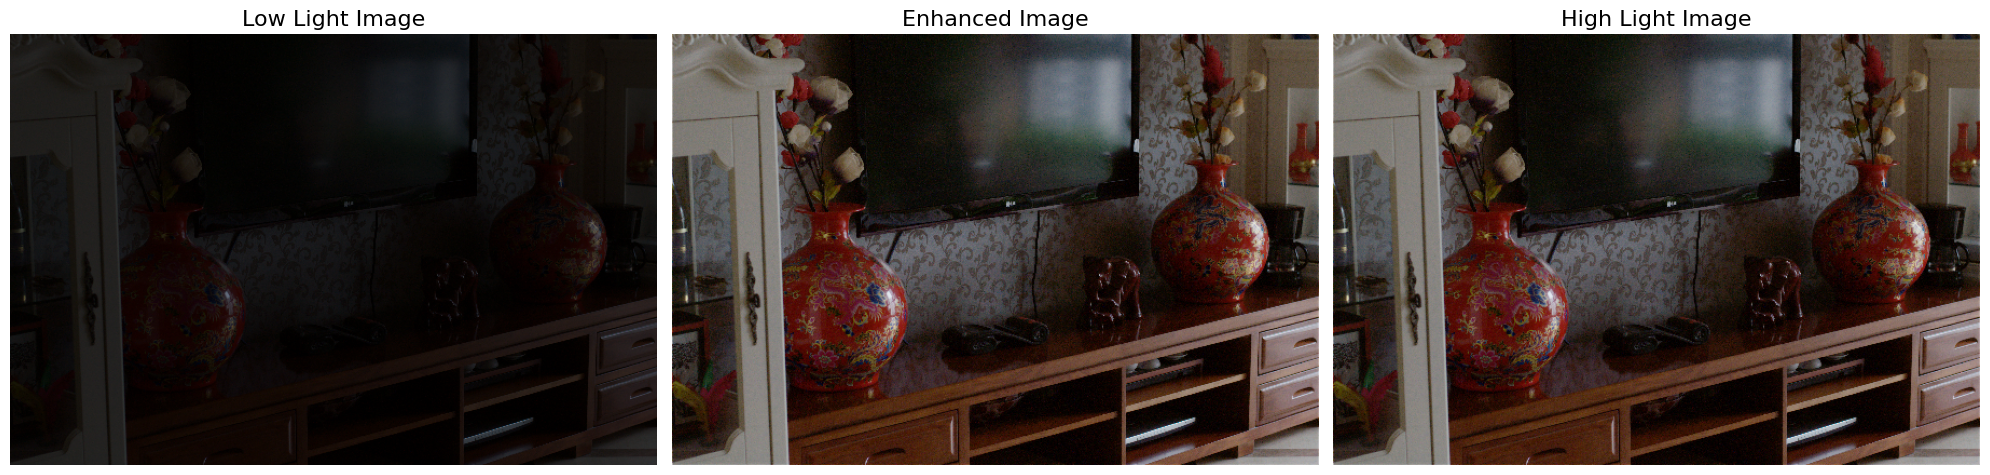

In [46]:
# Test 3:

low_light_image = X[150]
high_light_image = Y[150]
psnr_list = []
enhanced_image = enhance_image(low_light_image, 8, 1, psnr_list)
print("Average PSNR value of Enhanced Image: " , sum(psnr_list)/len(psnr_list))
plot_images(low_light_image, enhanced_image, high_light_image)

1/1 [==============================] - 0s 32ms/step
PSNR: -11.4482
1/1 [==============================] - 0s 33ms/step
PSNR: 41.6990
1/1 [==============================] - 0s 37ms/step
PSNR: 40.3463
1/1 [==============================] - 0s 35ms/step
PSNR: 39.0422
1/1 [==============================] - 0s 36ms/step
PSNR: 37.7964
1/1 [==============================] - 0s 37ms/step
PSNR: 36.6109
1/1 [==============================] - 0s 47ms/step
PSNR: 35.4970
1/1 [==============================] - 0s 38ms/step
PSNR: 34.4647
Average PSNR value of Enhanced Image:  31.75104284286499


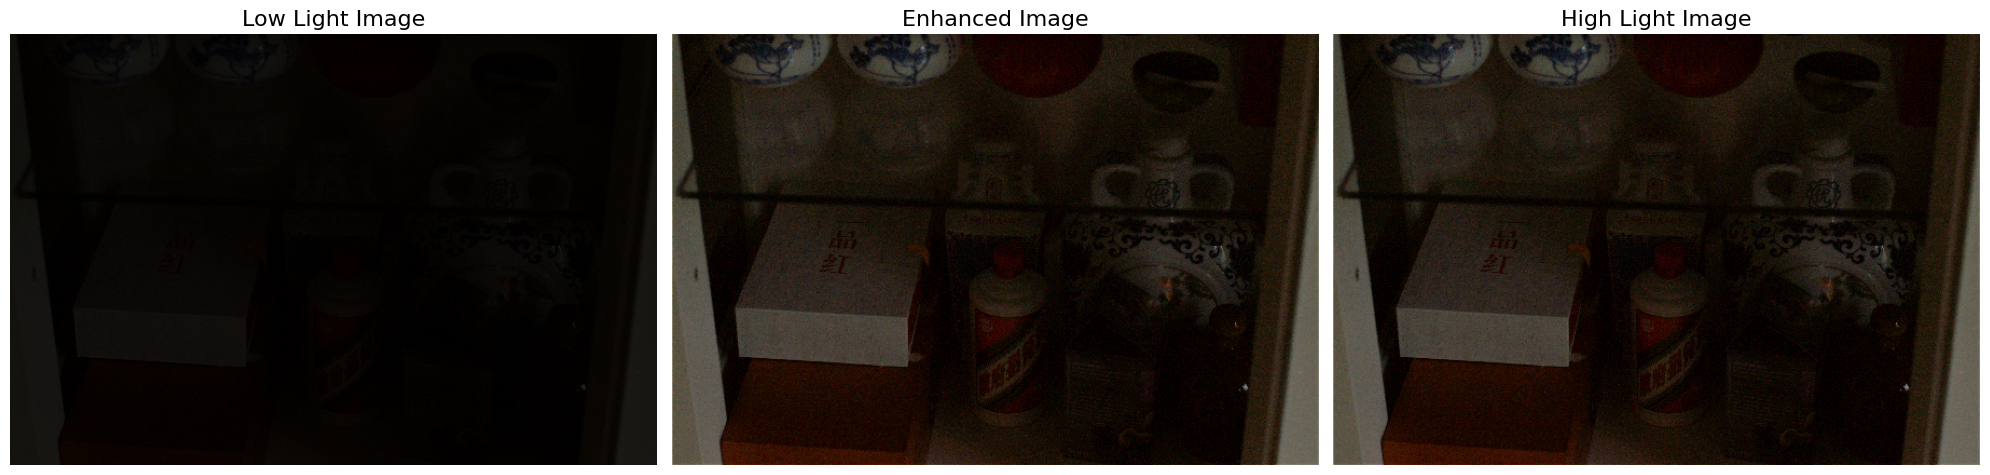

In [51]:
# Test 4:

low_light_image = X[160]
high_light_image = Y[160]
psnr_list = []
enhanced_image = enhance_image(low_light_image, 8, 1, psnr_list)
print("Average PSNR value of Enhanced Image: " , sum(psnr_list)/len(psnr_list))
plot_images(low_light_image, enhanced_image, high_light_image)